Cryptocurrency trading bot.

Global variable definitions.

In [1]:
traded_asset_symbols = ['BTC', 'USDT']
intervals = ['1d']
raw_price = False
initial_plot = True

api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install python-binance --upgrade --no-cache-dir
!pip install plotly stocktrends

Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from stocktrends import Renko
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Function definitions.

In [4]:
class Cryptocurrency_indicator:
    def __init__(self, name, calculate, OHLC=False):
        self.name = name
        self.calculate = calculate
        self.plot = self._plot_OHLC_ if OHLC else self._plot_default_
        self.value = None

    def update(self, dataset, plot=False):
        self.value = self.calculate(dataset.astype(float))

        if plot:
            self.plot()

    def _plot_default_(self):
        value = self.value.astype(float)

        print("\n")
        print(self.name)
        print(value)
        plt.plot(value)
        plt.show()
        print("\n")

    def _plot_OHLC_(self):
        value = self.value.astype(float)

        print("\n")
        print(self.name)
        print(self.value)
        fig = go.Figure(data=[go.Candlestick(x=value.index.to_series(), 
                                             open=value['open'], 
                                             high=value['high'], 
                                             low=value['low'], 
                                             close=value['close'])])

        fig.show()
        print("\n")


class Cryptocurrency_indicators_base:
    def _calculate_moving_average_(self, dataset, window=2, method='simple'):
        if method == 'simple':
            dataset = dataset.rolling(window=window)
        elif method == 'exponential':
            dataset = dataset.ewm(span=window)

        dataset = dataset.mean()
        dataset = dataset.fillna(method='backfill', axis='index')
        return dataset

    def calculate_simple_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='simple')

    def calculate_exponential_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='exponential')

    def calculate_renko(self, dataset, brick_size=1):
        renko_ = dataset[['open', 'high', 'low', 'close']].copy().astype(float)
        renko_.index.name = 'date'
        renko_ = Renko(renko_.reset_index())
        renko_.brick_size = brick_size
        renko_ = renko_.get_ohlc_data().set_index('date')
        renko_.index.name = 'time'
        return renko_.uptrend

    def calculate_heikin_ashi(self, df):
        df = df.tz_localize(tz=None, ambiguous='infer')
        df = df[['open', 'high', 'low', 'close']].copy().astype('float')
        heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
        heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

        for i in range(len(df)):
            if i == 0:
                heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
            else:
                heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

        heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
        heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

        return heikin_ashi_df

    def calculate_RSI(self, ticker, span=14):
        up = ticker['close'].astype(float).pct_change()
        down = up.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        up = up.ewm(span=span).mean().fillna(method='pad')
        down = down.ewm(span=span).mean().abs().fillna(method='pad')

        ticker = up / down
        ticker = 100 - (100 / (1 + ticker))

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        return ticker.fillna(method='pad')

    def calculate_MACD(self, ticker, span1=12, span2=26, average='exponential'):
        shorter = self._calculate_moving_average_(ticker, window=span1, method=average)['close']
        longer = self._calculate_moving_average_(ticker, window=span2, method=average)['close']

        ticker = (shorter - longer).replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        ticker = ticker.fillna(method='pad').to_frame(name='MACD')
        ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
        ticker['histogram'] = ticker.MACD - ticker.signal_line
        return ticker

    def calculate_ATR(self, ticker, min_periods=14):
        ticker = ticker.astype(float)
        up = pd.DataFrame([ticker['high'].shift(), 
                           ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

        down = pd.DataFrame([ticker['low'].shift(), 
                             ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

        ticker = (up - down).ewm(alpha=1 / min_periods, 
                                 min_periods=min_periods, 
                                 adjust=False).mean()

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        return ticker.fillna(method='backfill')

    def calculate_bollinger_bands(self, dataframe, period=20):
        df = dataframe.copy()
        df['MA'] = self._calculate_moving_average_(df, window=period, method='simple')['close']
        df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
        df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
        df['BB_width'] = df['BB_up'] - df['BB_down']
        return df[['BB_up', 'BB_down', 'BB_width']].dropna()

    def calculate_average_directional_index(self, df, n=14, n_ADX=14):
        dataset_index = df.index.copy()
        df = df.reset_index().drop(columns=['time']).astype(float)
        i = 0
        UpI = []
        DoI = []

        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']

            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0

            UpI.append(UpD)

            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0

            DoI.append(DoD)
            i += 1

        ATR = self.calculate_ATR(df, min_periods=14)
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR, name='PosDI')
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR, name='NegDI')
        ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, 
                                                                   min_periods=n_ADX).mean(), 
                        name='ADX')

        df = df.join(ADX).join(PosDI).join(NegDI)
        df.index = dataset_index
        return df[['ADX', 'PosDI', 'NegDI']].dropna()

    def calculate_commodity_channel_index(self, dataset, min_periods=20):
        PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
        CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                        PP.rolling(min_periods, min_periods=min_periods).std(),
                        name='CCI')
        return dataset.join(CCI)['CCI']

    def calculate_KDJ(self, dataset):
        def get_rsv(dataset):
            low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
            high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
            return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

        def calc_kd(column):
            k = 50.0
            for i in (1.0 / 3.0) * column:
                k = (2.0 / 3.0) * k + i
                yield k

        dataset['K'] = list(calc_kd(get_rsv(dataset)))
        dataset['D'] = list(calc_kd(dataset['K']))
        dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
        return dataset[['K', 'D', 'J']]

    def calculate_relative_volume_level(self, 
                                        dataset, 
                                        average_1=26, 
                                        average_2=14, 
                                        threshold=1.75, 
                                        method='exponential'):

        volume = dataset[['volume']]
        volume_average = self._calculate_moving_average_(volume, window=average_1, method=method)
        relative_volume = volume / average_1
        smoothed_relative_volume = self._calculate_moving_average_(relative_volume, window=average_2, method=method)
        relative_volume_level = smoothed_relative_volume.iloc[-1] / smoothed_relative_volume.iloc[-2]
        return relative_volume_level > threshold


class Cryptocurrency_indicators:
    def __init__(self, dataset, plot):
        self.indicators = Cryptocurrency_indicators_base()
        self.setup(self)
        self.update(dataset, plot=plot)

    def setup(self, cls):
        for cls in [cls.indicators, cls]:
            indicators = [indicator for indicator in dir(cls) if indicator.startswith('calculate_')]
            calculators = [getattr(cls, indicator) for indicator in indicators]

            for indicator, calculator in zip(indicators, calculators):
                setattr(cls, 
                        indicator[10:], 
                        Cryptocurrency_indicator(name=indicator[10:], 
                                                 calculate=calculator, 
                                                 OHLC=False))

    def update(self, dataset, plot=False):
        for cls in [self.indicators, self]:
            indicators = [indicator for indicator in dir(cls)]
            calculators = [getattr(cls, indicator) for indicator in indicators]

            for calculator in calculators:
                if isinstance(calculator, Cryptocurrency_indicator):
                    calculator.update(dataset, plot=plot)

    def calculate_trend_trigger(self, dataset):
        heikin_ashi = self.indicators.calculate_simple_moving_average(dataset, window=1)
        heikin_ashi = self.indicators.calculate_heikin_ashi(heikin_ashi)
        heikin_ashi = self.indicators.calculate_exponential_moving_average(dataset, window=1)
        return (heikin_ashi['close'] - heikin_ashi['open']) > 0

    def calculate_overtraded_trigger(self, dataset):
        RSI_6 = self.indicators.calculate_RSI(dataset, span=6)
        RSI_12 = self.indicators.calculate_RSI(dataset, span=12)
        return RSI_6 > RSI_12

    def calculate_trend_strength_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['ADX'] > 0.25

    def calculate_trend_strength_positive_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] > ADX['NegDI']

    def calculate_trend_strength_negative_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] < ADX['NegDI']

    def calculate_momentum_trigger(self, dataset):
        KDJ = self.indicators.calculate_KDJ(dataset)
        return KDJ['J'] > KDJ['D']

    def calculate_volatility_trigger(self, dataset):
        bollinger_bands = self.indicators.calculate_bollinger_bands(dataset, period=20)
        return (bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def calculate_MACD_trigger(self, dataset):
        MACD = self.indicators.calculate_MACD(dataset)
        return MACD['histogram'] > 0

    def calculate_real_trigger(self, dataset):
        return (dataset['close'] - dataset['open']) > 0


class Cryptocurrency_pair_info:
    def __init__(self, client, pair):
        self.client = client
        self.pair = pair

        pair_info = client.get_symbol_info(self.pair)
        self.base_asset = pair_info['baseAsset']
        self.quote_asset = pair_info['quoteAsset']
        self.precision = pair_info['quotePrecision']

        filters = pair_info['filters']
        price_filter = [ticker for ticker in filters if ticker['filterType'] == 'PRICE_FILTER']
        lot_size = [ticker for ticker in filters if ticker['filterType'] == 'LOT_SIZE']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in price_filter][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in lot_size][0]

        self.calculate_balance()

    def calculate_balance(self):
        self.base_asset_balance = float(self.client.get_asset_balance(asset=self.base_asset)['free'])
        self.quote_asset_balance = float(self.client.get_asset_balance(asset=self.quote_asset)['free'])
        self.pair_last_price = float(self.client.get_ticker(symbol=self.pair)['lastPrice'])
        self.pair_buy_balance = self.quote_asset_balance / self.pair_last_price
        self.pair_sell_balance = self.base_asset_balance * self.pair_last_price
        self.pair_combined_base_balance = self.pair_buy_balance + self.base_asset_balance
        self.pair_combined_quote_balance = self.pair_sell_balance + self.quote_asset_balance

    def print_balance(self):
        print('base_asset_balance: ', self.base_asset_balance)
        print('quote_asset_balance: ', self.quote_asset_balance)
        print('pair_last_price: ', self.pair_last_price)
        print('pair_buy_balance: ', self.pair_buy_balance)
        print('pair_sell_balance: ', self.pair_sell_balance)
        print('pair_combined_base_balance: ', self.pair_combined_base_balance)
        print('pair_combined_quote_balance: ', self.pair_combined_quote_balance)


class Cryptocurrency_pair_at_interval:
    def __init__(self, client, info, interval, download=True, initial_plot=True):
        self.dataset = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
        self.interval = interval
        self.period = self.get_n_periods_from_time(n=100)
        self.indicators = None

        if download:
            self.dataset = self.download_dataset(client=client, symbol=info.pair)

        if self.interval != 'price':
            self.indicators = Cryptocurrency_indicators(self.dataset, plot=initial_plot)

    def get_n_periods_from_time(self, n=100):
        return str(int(self.interval[:-1]) * n) + self.interval[-1:]

    def download_dataset(self, client, symbol):
        if self.interval == 'price':
            return pd.DataFrame(client.get_recent_trades(symbol=symbol))
        else:
            dataset_downloaded = \
                client.get_historical_klines(symbol=symbol, 
                                             interval=self.interval, 
                                             start_str=self.period)

            dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                              columns=['time', 
                                                       'open', 
                                                       'high', 
                                                       'low', 
                                                       'close', 
                                                       'volume', 
                                                       'Close time', 
                                                       'Quote asset volume', 
                                                       'Number of trades', 
                                                       'Taker buy base asset volume', 
                                                       'Taker buy quote asset volume', 
                                                       'Ignore'])

            four_hours = 14400
            milliseconds = 1000

            dataset_downloaded['time'] = \
                dataset_downloaded['time'].apply(lambda timestamp: \
                                                 datetime.datetime.fromtimestamp((timestamp / \
                                                                                  milliseconds) - \
                                                                                 four_hours))

            dataset_downloaded = dataset_downloaded[['time', 
                                                     'open', 
                                                     'high', 
                                                     'low', 
                                                     'close', 
                                                     'volume']]

            dataset_downloaded.set_index('time', inplace=True)
            return dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))


class Cryptocurrency_trader:
    def __init__(self, pair):
        self.state = 'entry'
        self.is_tradable = True
        self.pair = pair
        self.info = self.pair.info

        self.calculate_position()

    def calculate_position(self):
        if self.info.pair_buy_balance > self.info.base_asset_balance:
            self.position = 'sell'
        elif self.info.base_asset_balance > self.info.pair_buy_balance:
            self.position = 'buy'

    def trade(self, percentage_to_trade=0.999999):
        if self.position == 'sell':
            coins_available = self.info.pair_buy_balance
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = self.info.pair_sell_balance
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.info.step_size) / \
                        float(10**self.info.step_size)

        if self.info.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.info.tick_size)) / \
                            float(abs(self.info.tick_size))

        client.create_order(symbol=self.info.pair, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.pair.info.calculate_balance()
        self.pair.info.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.info.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.info.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position


class Cryptocurrency_pair(Cryptocurrency_trader):
    def __init__(self, 
                 client, 
                 pair, 
                 intervals=intervals, 
                 raw_price=True, 
                 download=True, 
                 initial_plot=True):

        self.raw_price = raw_price
        self.download = download

        self.info = self.get_pair_info(client, pair)
        super().__init__(self)
        self.interval = self.get_datasets(client, intervals, initial_plot=initial_plot)

    def get_pair_info(self, client, pair):
        return Cryptocurrency_pair_info(client=client, pair=pair)

    def get_datasets(self, client, intervals, initial_plot=True):
        dataset = dict()

        if self.raw_price:
            dataset['price'] = Cryptocurrency_pair_at_interval(client=client, 
                                                               info=self.info, 
                                                               interval='price', 
                                                               download=self.download, 
                                                               initial_plot=initial_plot)

        for interval in intervals:
            dataset[interval] = Cryptocurrency_pair_at_interval(client=client, 
                                                                info=self.info, 
                                                                interval=interval, 
                                                                download=self.download, 
                                                                initial_plot=initial_plot)

        return dataset

    def make_OHLC_dataset(self, dataset, interval=intervals[0]):
        dataset = dataset.resample(interval)
        volume = dataset.agg({'quantity': ['sum']})['quantity']
        dataset = dataset.agg({'price': ['first', 'max', 'min', 'last']})['price']
        dataset['volume'] = volume
        dataset = dataset.dropna(axis='index')
        dataset = dataset.rename(columns={'first': 'open', 
                                          'max': 'high', 
                                          'min': 'low', 
                                          'last': 'close', 
                                          'sum': 'volume'})

        return dataset


class Cryptocurrency_bot:
    def __init__(self, 
                 client, 
                 traded_asset_symbols=traded_asset_symbols, 
                 intervals=intervals, 
                 raw_price=True, 
                 initial_plot=True):

        self.all_symbols = self.get_all_symbols(client)
        traded_pair_symbols = self.get_traded_pairs_from_assets(traded_asset_symbols)

        self.pairs = self.get_pairs(client, 
                                    intervals, 
                                    raw_price, 
                                    traded_pair_symbols, 
                                    initial_plot=initial_plot)

        self.traded_asset_symbol = self.get_richest_asset(traded_asset_symbols, traded_pair_symbols)
        self.traded_pair_symbol = self.get_most_promising_pair()

    def get_most_promising_pair(self):
        tradable_pair_symbols = []

        for symbol in self.pairs.keys():
            if self.pairs[symbol].is_tradable is True and \
                    (self.pairs[symbol].info.base_asset == self.traded_asset_symbol or \
                     self.pairs[symbol].info.quote_asset == self.traded_asset_symbol):
                tradable_pair_symbols.append(symbol)

        return random.choice(tradable_pair_symbols)

    def get_all_symbols(self, client):
        return [symbol['symbol'] for symbol in client.get_all_tickers()]

    def get_traded_pairs_from_assets(self, traded_asset_symbols):
        traded_pair_symbols = []
        for base_asset in traded_asset_symbols:
            for quote_asset in traded_asset_symbols:
                if base_asset != quote_asset:
                    for pair in [base_asset + quote_asset, quote_asset + base_asset]:
                        if pair in self.all_symbols:
                            traded_pair_symbols.append(pair)

        return traded_pair_symbols

    def get_pairs(self, 
                  client, 
                  intervals, 
                  raw_price, 
                  traded_pair_symbols, 
                  initial_plot=True):

        pairs = dict()
        for pair in traded_pair_symbols:
            pairs[pair] = Cryptocurrency_pair(client=client, 
                                              pair=pair, 
                                              intervals=intervals, 
                                              raw_price=raw_price, 
                                              download=True, 
                                              initial_plot=initial_plot)

        return pairs

    def get_richest_asset(self, traded_asset_symbols, traded_pair_symbols):
        richest_count = dict()
        for traded_asset_symbol in traded_asset_symbols:
            richest_count.update({traded_asset_symbol: 0})

        for traded_pair_symbol in traded_pair_symbols:
            base_asset = self.pairs[traded_pair_symbol].info.base_asset
            quote_asset = self.pairs[traded_pair_symbol].info.quote_asset
            if self.pairs[traded_pair_symbol].info.base_asset_balance >= \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({base_asset: richest_count[base_asset] + 1})
            elif self.pairs[traded_pair_symbol].info.base_asset_balance < \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({quote_asset: richest_count[quote_asset] + 1})

        return max(richest_count, key=richest_count.get)



ATR
time
2020-03-07 15:00:00    1137.728977
2020-03-08 16:00:00    1137.728977
2020-03-09 16:00:00    1137.728977
2020-03-10 16:00:00    1137.728977
2020-03-11 16:00:00    1137.728977
                          ...     
2020-06-10 16:00:00     531.576074
2020-06-11 16:00:00     554.392069
2020-06-12 16:00:00     537.979064
2020-06-13 16:00:00     510.454131
2020-06-14 16:00:00     490.849550
Length: 100, dtype: float64


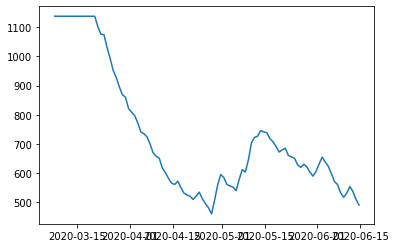





KDJ
                             K          D          J
time                                                
2020-03-07 15:00:00  34.585457  44.861819  14.032733
2020-03-08 16:00:00  30.969836  40.231158  12.447192
2020-03-09 16:00:00  27.621386  36.027901  10.808357
2020-03-10 16:00:00  27.270175  33.108659  15.593208
2020-03-11 16:00:00  21.084003  29.100440   5.051128
...                        ...        ...        ...
2020-06-10 16:00:00  41.278221  47.659360  28.515942
2020-06-11 16:00:00  40.861317  45.393346  31.797259
2020-06-12 16:00:00  40.894465  43.893719  34.895956
2020-06-13 16:00:00  35.943769  41.243736  25.343835
2020-06-14 16:00:00  40.932400  41.139957  40.517286

[100 rows x 3 columns]


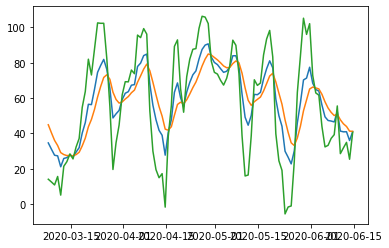





MACD
                           MACD  signal_line  histogram
time                                                   
2020-03-07 15:00:00   -2.320769    -2.320769   0.000000
2020-03-08 16:00:00   -2.320769    -2.320769   0.000000
2020-03-09 16:00:00   -4.052082    -3.030323  -1.021758
2020-03-10 16:00:00   -3.297470    -3.120820  -0.176649
2020-03-11 16:00:00 -127.547769   -40.135024 -87.412745
...                         ...          ...        ...
2020-06-10 16:00:00  169.633963   214.250575 -44.616612
2020-06-11 16:00:00  144.403333   200.281127 -55.877793
2020-06-12 16:00:00  123.644726   184.953846 -61.309121
2020-06-13 16:00:00   95.507281   167.064533 -71.557253
2020-06-14 16:00:00   81.889102   150.029447 -68.140345

[100 rows x 3 columns]


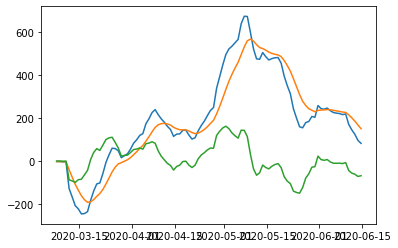





RSI
time
2020-03-07 15:00:00     0.000000
2020-03-08 16:00:00     0.000000
2020-03-09 16:00:00     0.000000
2020-03-10 16:00:00    27.224652
2020-03-11 16:00:00     1.066932
                         ...    
2020-06-10 16:00:00    40.088490
2020-06-11 16:00:00    46.973377
2020-06-12 16:00:00    47.278007
2020-06-13 16:00:00    42.751870
2020-06-14 16:00:00    48.043598
Name: close, Length: 100, dtype: float64


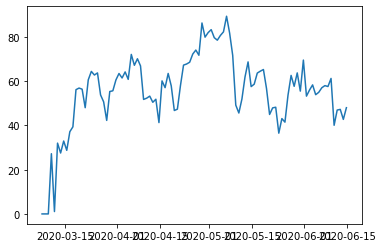





average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-04-02 16:00:00  0.130592  0.145150  0.096605
2020-04-03 16:00:00  0.141193  0.129516  0.086200
2020-04-04 16:00:00  0.185821  0.200595  0.077624
2020-04-05 16:00:00  0.229252  0.194206  0.067712
2020-04-06 16:00:00  0.265865  0.170402  0.059412
...                       ...       ...       ...
2020-06-09 16:00:00  0.321473  0.138898  0.214378
2020-06-10 16:00:00  0.307098  0.117230  0.180935
2020-06-11 16:00:00  0.294639  0.097418  0.150356
2020-06-12 16:00:00  0.294967  0.087005  0.160556
2020-06-13 16:00:00  0.321375  0.079470  0.234038

[73 rows x 3 columns]


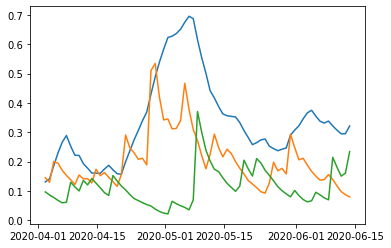





bollinger_bands
                           BB_up      BB_down    BB_width
time                                                     
2020-03-26 16:00:00  6289.935000  6289.935000    0.000000
2020-03-27 16:00:00  6220.189269  6180.014731   40.174539
2020-03-28 16:00:00  6144.162915  6051.196085   92.966829
2020-03-29 16:00:00  6095.714475  5949.626525  146.087949
2020-03-30 16:00:00  6047.663691  5845.269309  202.394382
...                          ...          ...         ...
2020-06-10 16:00:00  9580.767682  9411.476318  169.291364
2020-06-11 16:00:00  9599.849372  9420.992628  178.856744
2020-06-12 16:00:00  9643.644048  9452.497952  191.146095
2020-06-13 16:00:00  9671.545975  9468.771025  202.774951
2020-06-14 16:00:00  9708.001859  9494.340141  213.661717

[81 rows x 3 columns]


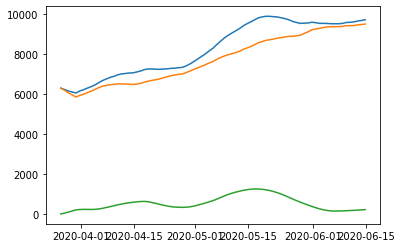





commodity_channel_index
time
2020-03-07 15:00:00         NaN
2020-03-08 16:00:00         NaN
2020-03-09 16:00:00         NaN
2020-03-10 16:00:00         NaN
2020-03-11 16:00:00         NaN
                         ...   
2020-06-10 16:00:00   -0.077755
2020-06-11 16:00:00   -0.218882
2020-06-12 16:00:00   -0.258084
2020-06-13 16:00:00   -0.726304
2020-06-14 16:00:00   -1.315534
Name: CCI, Length: 100, dtype: float64


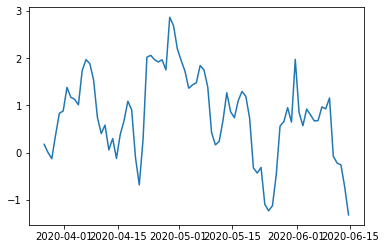





exponential_moving_average
                            open         high          low        close  \
time                                                                      
2020-03-07 15:00:00  8885.250000  8886.760000  8000.000000  8033.310000   
2020-03-08 16:00:00  8247.382500  8356.172500  7724.007500  7955.730000   
2020-03-09 16:00:00  8027.566154  8212.745385  7726.778462  7913.381538   
2020-03-10 16:00:00  7937.793750  8055.642250  7634.453000  7927.650000   
2020-03-11 16:00:00  7935.642397  7995.747603  5475.934876  5833.933884   
...                          ...          ...          ...          ...   
2020-06-10 16:00:00  9846.388490  9957.786089  9294.913435  9469.012180   
2020-06-11 16:00:00  9468.049497  9690.675363  9253.311145  9466.424060   
2020-06-12 16:00:00  9465.989832  9560.045121  9318.437048  9471.034687   
2020-06-13 16:00:00  9470.889944  9507.341707  9269.479016  9385.078229   
2020-06-14 16:00:00  9385.029981  9499.113902  9030.126339  9435.9794

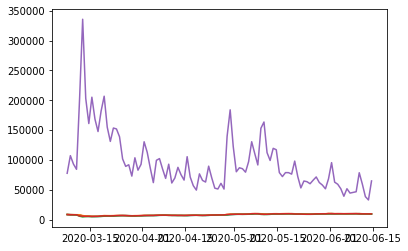





heikin_ashi
                            open         high      low      close
2020-03-07 15:00:00  8885.250000  8886.760000  8000.00  8451.3300
2020-03-08 16:00:00  8668.290000  8668.290000  7632.01  7943.9875
2020-03-09 16:00:00  8306.138750  8306.138750  7728.01  7925.3600
2020-03-10 16:00:00  8115.749375  8115.749375  7590.00  7849.7725
2020-03-11 16:00:00  7982.760937  7982.760937  4410.00  6277.6875
...                          ...          ...      ...        ...
2020-06-10 16:00:00  9781.478484  9964.000000  9113.00  9560.6550
2020-06-11 16:00:00  9671.066742  9671.066742  9232.51  9383.4100
2020-06-12 16:00:00  9527.238371  9527.238371  9351.00  9446.0075
2020-06-13 16:00:00  9486.622935  9486.622935  9245.00  9385.3575
2020-06-14 16:00:00  9435.990218  9495.000000  8910.45  9302.2450

[100 rows x 4 columns]


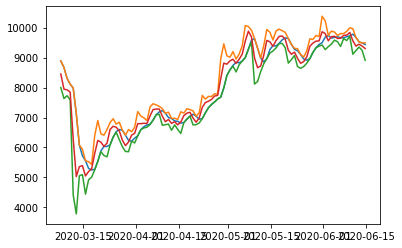





relative_volume_level
volume    0.0
dtype: float64


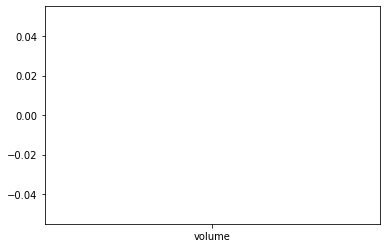





renko
time
2020-03-07 15:00:00    1.0
2020-03-08 16:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-08 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-14 16:00:00    1.0
Name: uptrend, Length: 25969, dtype: float64


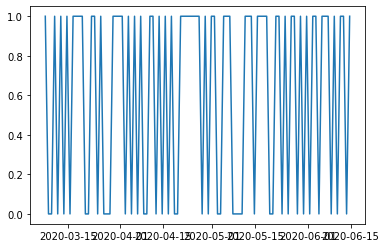





simple_moving_average
                         open      high       low     close         volume
time                                                                      
2020-03-07 15:00:00  8460.005  8533.035  7816.005  7981.590   97253.089217
2020-03-08 16:00:00  8460.005  8533.035  7816.005  7981.590   97253.089217
2020-03-09 16:00:00  7982.315  8164.155  7680.010  7912.215  101876.153572
2020-03-10 16:00:00  7912.220  8064.500  7659.005  7914.540   83362.927523
2020-03-11 16:00:00  7914.575  7973.085  6000.000  6367.260  170724.009912
...                       ...       ...       ...       ...            ...
2020-06-10 16:00:00  9828.830  9978.360  9408.590  9582.700   70774.873856
2020-06-11 16:00:00  9582.050  9760.560  9172.755  9372.765   72269.025831
2020-06-12 16:00:00  9371.920  9525.925  9291.755  9469.235   38939.425891
2020-06-13 16:00:00  9469.150  9487.860  9298.000  9407.720   28907.645729
2020-06-14 16:00:00  9407.720  9487.995  9077.725  9401.765   55352.082058

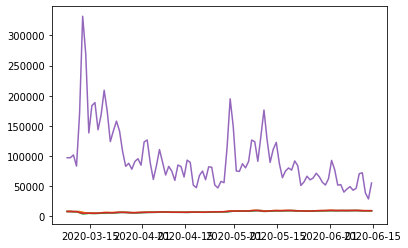





MACD_trigger
time
2020-03-07 15:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-09 16:00:00    0.0
2020-03-10 16:00:00    0.0
2020-03-11 16:00:00    0.0
                      ... 
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
Name: histogram, Length: 100, dtype: float64


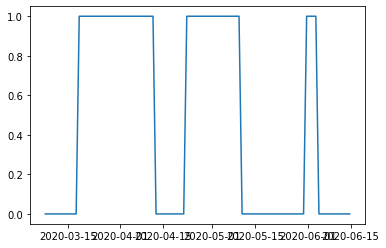





momentum_trigger
time
2020-03-07 15:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-09 16:00:00    0.0
2020-03-10 16:00:00    0.0
2020-03-11 16:00:00    0.0
                      ... 
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
Length: 100, dtype: float64


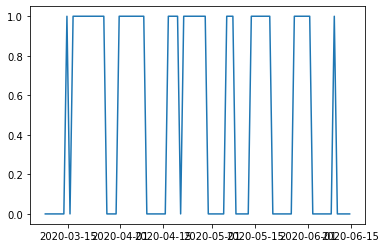





overtraded_trigger
time
2020-03-07 15:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-09 16:00:00    0.0
2020-03-10 16:00:00    1.0
2020-03-11 16:00:00    0.0
                      ... 
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    1.0
Name: close, Length: 100, dtype: float64


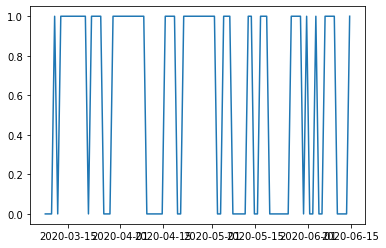





real_trigger
time
2020-03-07 15:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-09 16:00:00    0.0
2020-03-10 16:00:00    1.0
2020-03-11 16:00:00    0.0
                      ... 
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    1.0
Length: 100, dtype: float64


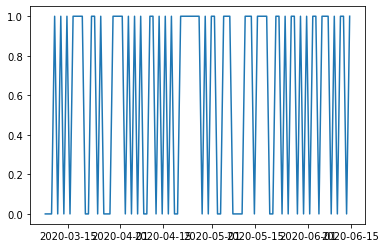





trend_strength_negative_trigger
time
2020-04-02 16:00:00    0.0
2020-04-03 16:00:00    0.0
2020-04-04 16:00:00    0.0
2020-04-05 16:00:00    0.0
2020-04-06 16:00:00    0.0
                      ... 
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
Length: 73, dtype: float64


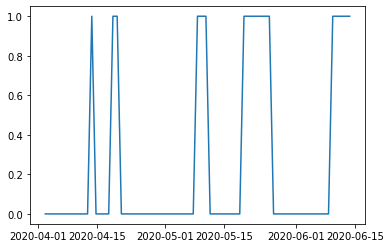





trend_strength_positive_trigger
time
2020-04-02 16:00:00    1.0
2020-04-03 16:00:00    1.0
2020-04-04 16:00:00    1.0
2020-04-05 16:00:00    1.0
2020-04-06 16:00:00    1.0
                      ... 
2020-06-09 16:00:00    0.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
Length: 73, dtype: float64


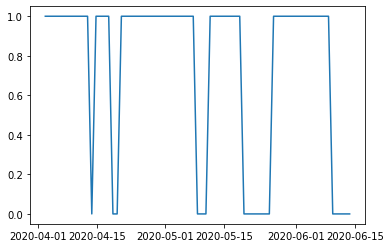





trend_strength_trigger
time
2020-04-02 16:00:00    0.0
2020-04-03 16:00:00    0.0
2020-04-04 16:00:00    0.0
2020-04-05 16:00:00    0.0
2020-04-06 16:00:00    1.0
                      ... 
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
Name: ADX, Length: 73, dtype: float64


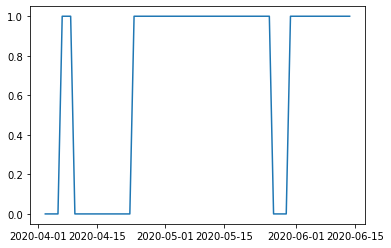





trend_trigger
time
2020-03-07 15:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-09 16:00:00    0.0
2020-03-10 16:00:00    1.0
2020-03-11 16:00:00    0.0
                      ... 
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    1.0
Length: 100, dtype: float64


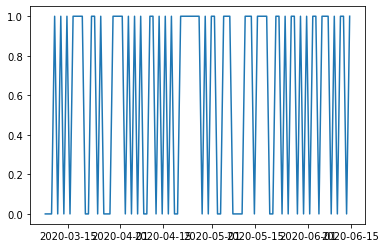





volatility_trigger
time
2020-03-07 15:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-09 16:00:00    0.0
2020-03-10 16:00:00    0.0
2020-03-11 16:00:00    0.0
                      ... 
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
2020-06-14 16:00:00    1.0
Length: 100, dtype: float64


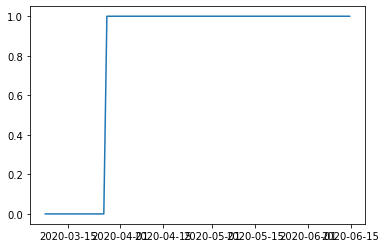





ATR
time
2020-03-07 15:00:00    1137.728977
2020-03-08 16:00:00    1137.728977
2020-03-09 16:00:00    1137.728977
2020-03-10 16:00:00    1137.728977
2020-03-11 16:00:00    1137.728977
                          ...     
2020-06-10 16:00:00     531.576074
2020-06-11 16:00:00     554.392069
2020-06-12 16:00:00     537.979064
2020-06-13 16:00:00     510.454131
2020-06-14 16:00:00     490.849550
Length: 100, dtype: float64


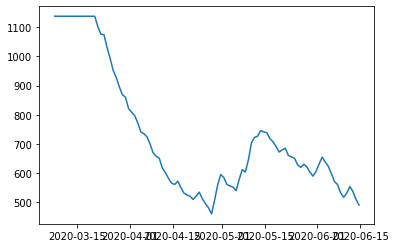





KDJ
                             K          D          J
time                                                
2020-03-07 15:00:00  34.585457  44.861819  14.032733
2020-03-08 16:00:00  30.969836  40.231158  12.447192
2020-03-09 16:00:00  27.621386  36.027901  10.808357
2020-03-10 16:00:00  27.270175  33.108659  15.593208
2020-03-11 16:00:00  21.084003  29.100440   5.051128
...                        ...        ...        ...
2020-06-10 16:00:00  41.278221  47.659360  28.515942
2020-06-11 16:00:00  40.861317  45.393346  31.797259
2020-06-12 16:00:00  40.894465  43.893719  34.895956
2020-06-13 16:00:00  35.943769  41.243736  25.343835
2020-06-14 16:00:00  40.951804  41.146425  40.562561

[100 rows x 3 columns]


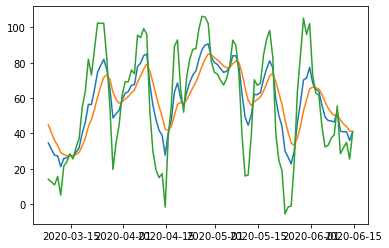





MACD
                           MACD  signal_line  histogram
time                                                   
2020-03-07 15:00:00   -2.320769    -2.320769   0.000000
2020-03-08 16:00:00   -2.320769    -2.320769   0.000000
2020-03-09 16:00:00   -4.052082    -3.030323  -1.021758
2020-03-10 16:00:00   -3.297470    -3.120820  -0.176649
2020-03-11 16:00:00 -127.547769   -40.135024 -87.412745
...                         ...          ...        ...
2020-06-10 16:00:00  169.633963   214.250575 -44.616612
2020-06-11 16:00:00  144.403333   200.281127 -55.877793
2020-06-12 16:00:00  123.644726   184.953846 -61.309121
2020-06-13 16:00:00   95.507281   167.064533 -71.557253
2020-06-14 16:00:00   81.939337   150.039494 -68.100157

[100 rows x 3 columns]


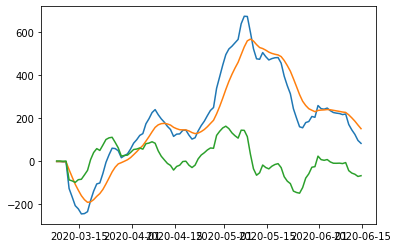





RSI
time
2020-03-07 15:00:00     0.000000
2020-03-08 16:00:00     0.000000
2020-03-09 16:00:00     0.000000
2020-03-10 16:00:00    27.224652
2020-03-11 16:00:00     1.066932
                         ...    
2020-06-10 16:00:00    40.088490
2020-06-11 16:00:00    46.973377
2020-06-12 16:00:00    47.278007
2020-06-13 16:00:00    42.751870
2020-06-14 16:00:00    48.068941
Name: close, Length: 100, dtype: float64


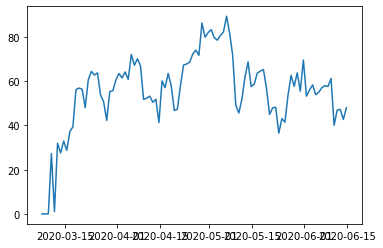





average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-04-02 16:00:00  0.130592  0.145150  0.096605
2020-04-03 16:00:00  0.141193  0.129516  0.086200
2020-04-04 16:00:00  0.185821  0.200595  0.077624
2020-04-05 16:00:00  0.229252  0.194206  0.067712
2020-04-06 16:00:00  0.265865  0.170402  0.059412
...                       ...       ...       ...
2020-06-09 16:00:00  0.321473  0.138898  0.214378
2020-06-10 16:00:00  0.307098  0.117230  0.180935
2020-06-11 16:00:00  0.294639  0.097418  0.150356
2020-06-12 16:00:00  0.294967  0.087005  0.160556
2020-06-13 16:00:00  0.321375  0.079470  0.234038

[73 rows x 3 columns]


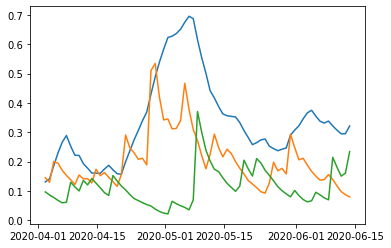





bollinger_bands
                           BB_up      BB_down    BB_width
time                                                     
2020-03-26 16:00:00  6289.935000  6289.935000    0.000000
2020-03-27 16:00:00  6220.189269  6180.014731   40.174539
2020-03-28 16:00:00  6144.162915  6051.196085   92.966829
2020-03-29 16:00:00  6095.714475  5949.626525  146.087949
2020-03-30 16:00:00  6047.663691  5845.269309  202.394382
...                          ...          ...         ...
2020-06-10 16:00:00  9580.767682  9411.476318  169.291364
2020-06-11 16:00:00  9599.849372  9420.992628  178.856744
2020-06-12 16:00:00  9643.644048  9452.497952  191.146095
2020-06-13 16:00:00  9671.545975  9468.771025  202.774951
2020-06-14 16:00:00  9708.036189  9494.368811  213.667379

[81 rows x 3 columns]


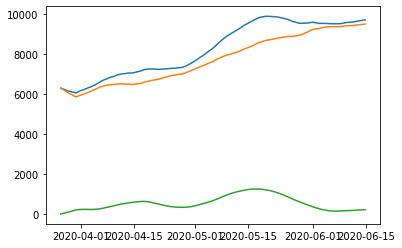





commodity_channel_index
time
2020-03-07 15:00:00         NaN
2020-03-08 16:00:00         NaN
2020-03-09 16:00:00         NaN
2020-03-10 16:00:00         NaN
2020-03-11 16:00:00         NaN
                         ...   
2020-06-10 16:00:00   -0.077755
2020-06-11 16:00:00   -0.218882
2020-06-12 16:00:00   -0.258084
2020-06-13 16:00:00   -0.726304
2020-06-14 16:00:00   -1.314672
Name: CCI, Length: 100, dtype: float64


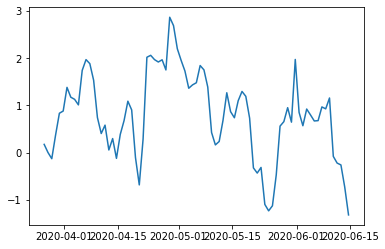





exponential_moving_average
                            open         high          low        close  \
time                                                                      
2020-03-07 15:00:00  8885.250000  8886.760000  8000.000000  8033.310000   
2020-03-08 16:00:00  8247.382500  8356.172500  7724.007500  7955.730000   
2020-03-09 16:00:00  8027.566154  8212.745385  7726.778462  7913.381538   
2020-03-10 16:00:00  7937.793750  8055.642250  7634.453000  7927.650000   
2020-03-11 16:00:00  7935.642397  7995.747603  5475.934876  5833.933884   
...                          ...          ...          ...          ...   
2020-06-10 16:00:00  9846.388490  9957.786089  9294.913435  9469.012180   
2020-06-11 16:00:00  9468.049497  9690.675363  9253.311145  9466.424060   
2020-06-12 16:00:00  9465.989832  9560.045121  9318.437048  9471.034687   
2020-06-13 16:00:00  9470.889944  9507.341707  9269.479016  9385.078229   
2020-06-14 16:00:00  9385.029981  9499.113902  9030.126339  9436.3994

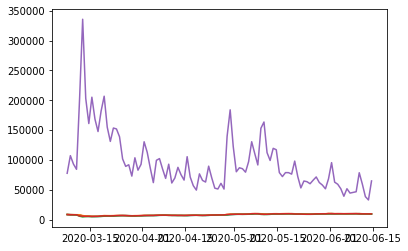





heikin_ashi
                            open         high      low      close
2020-03-07 15:00:00  8885.250000  8886.760000  8000.00  8451.3300
2020-03-08 16:00:00  8668.290000  8668.290000  7632.01  7943.9875
2020-03-09 16:00:00  8306.138750  8306.138750  7728.01  7925.3600
2020-03-10 16:00:00  8115.749375  8115.749375  7590.00  7849.7725
2020-03-11 16:00:00  7982.760937  7982.760937  4410.00  6277.6875
...                          ...          ...      ...        ...
2020-06-10 16:00:00  9781.478484  9964.000000  9113.00  9560.6550
2020-06-11 16:00:00  9671.066742  9671.066742  9232.51  9383.4100
2020-06-12 16:00:00  9527.238371  9527.238371  9351.00  9446.0075
2020-06-13 16:00:00  9486.622935  9486.622935  9245.00  9385.3575
2020-06-14 16:00:00  9435.990218  9495.000000  8910.45  9302.4025

[100 rows x 4 columns]


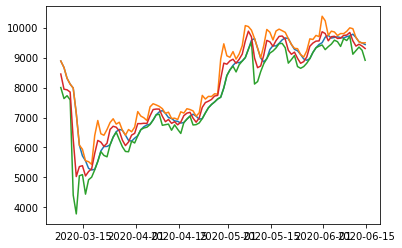





relative_volume_level
volume    0.0
dtype: float64


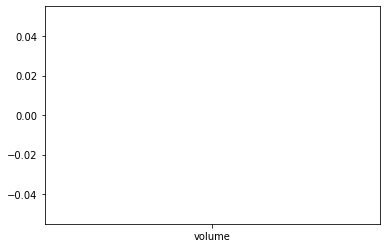





renko
time
2020-03-07 15:00:00    1.0
2020-03-08 16:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-08 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-14 16:00:00    1.0
Name: uptrend, Length: 25970, dtype: float64


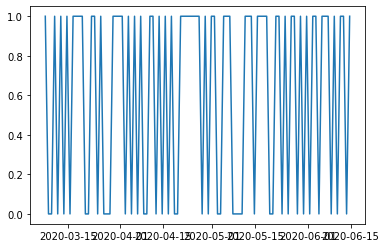





simple_moving_average
                         open      high       low     close         volume
time                                                                      
2020-03-07 15:00:00  8460.005  8533.035  7816.005  7981.590   97253.089217
2020-03-08 16:00:00  8460.005  8533.035  7816.005  7981.590   97253.089217
2020-03-09 16:00:00  7982.315  8164.155  7680.010  7912.215  101876.153572
2020-03-10 16:00:00  7912.220  8064.500  7659.005  7914.540   83362.927523
2020-03-11 16:00:00  7914.575  7973.085  6000.000  6367.260  170724.009912
...                       ...       ...       ...       ...            ...
2020-06-10 16:00:00  9828.830  9978.360  9408.590  9582.700   70774.873856
2020-06-11 16:00:00  9582.050  9760.560  9172.755  9372.765   72269.025831
2020-06-12 16:00:00  9371.920  9525.925  9291.755  9469.235   38939.425891
2020-06-13 16:00:00  9469.150  9487.860  9298.000  9407.720   28907.645729
2020-06-14 16:00:00  9407.720  9487.995  9077.725  9402.080   55352.665905

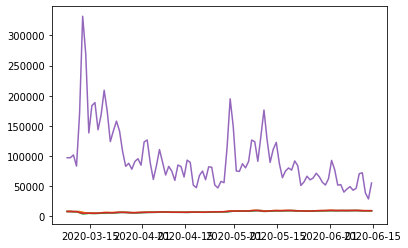





MACD_trigger
time
2020-03-07 15:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-09 16:00:00    0.0
2020-03-10 16:00:00    0.0
2020-03-11 16:00:00    0.0
                      ... 
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
Name: histogram, Length: 100, dtype: float64


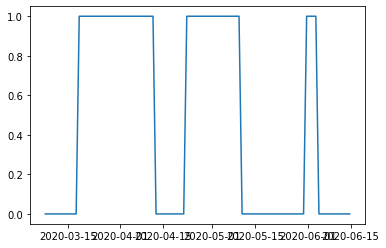





momentum_trigger
time
2020-03-07 15:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-09 16:00:00    0.0
2020-03-10 16:00:00    0.0
2020-03-11 16:00:00    0.0
                      ... 
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
Length: 100, dtype: float64


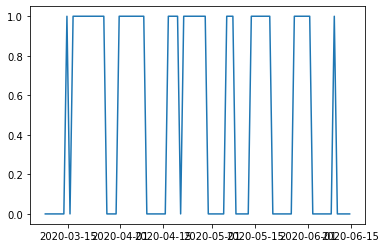





overtraded_trigger
time
2020-03-07 15:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-09 16:00:00    0.0
2020-03-10 16:00:00    1.0
2020-03-11 16:00:00    0.0
                      ... 
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    1.0
Name: close, Length: 100, dtype: float64


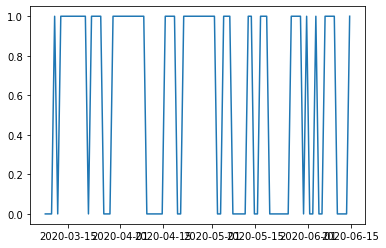





real_trigger
time
2020-03-07 15:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-09 16:00:00    0.0
2020-03-10 16:00:00    1.0
2020-03-11 16:00:00    0.0
                      ... 
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    1.0
Length: 100, dtype: float64


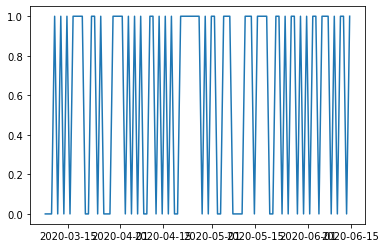





trend_strength_negative_trigger
time
2020-04-02 16:00:00    0.0
2020-04-03 16:00:00    0.0
2020-04-04 16:00:00    0.0
2020-04-05 16:00:00    0.0
2020-04-06 16:00:00    0.0
                      ... 
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
Length: 73, dtype: float64


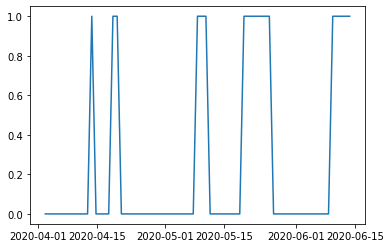





trend_strength_positive_trigger
time
2020-04-02 16:00:00    1.0
2020-04-03 16:00:00    1.0
2020-04-04 16:00:00    1.0
2020-04-05 16:00:00    1.0
2020-04-06 16:00:00    1.0
                      ... 
2020-06-09 16:00:00    0.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
Length: 73, dtype: float64


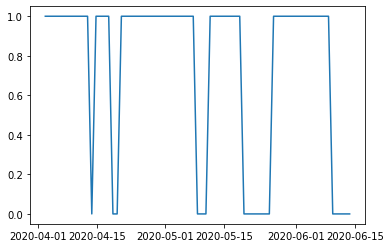





trend_strength_trigger
time
2020-04-02 16:00:00    0.0
2020-04-03 16:00:00    0.0
2020-04-04 16:00:00    0.0
2020-04-05 16:00:00    0.0
2020-04-06 16:00:00    1.0
                      ... 
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
Name: ADX, Length: 73, dtype: float64


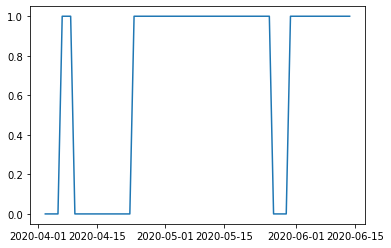





trend_trigger
time
2020-03-07 15:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-09 16:00:00    0.0
2020-03-10 16:00:00    1.0
2020-03-11 16:00:00    0.0
                      ... 
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    1.0
Length: 100, dtype: float64


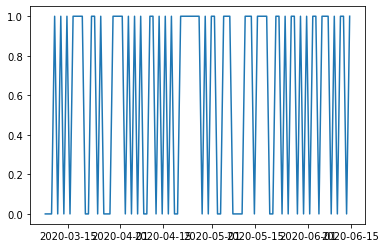





volatility_trigger
time
2020-03-07 15:00:00    0.0
2020-03-08 16:00:00    0.0
2020-03-09 16:00:00    0.0
2020-03-10 16:00:00    0.0
2020-03-11 16:00:00    0.0
                      ... 
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
2020-06-14 16:00:00    1.0
Length: 100, dtype: float64


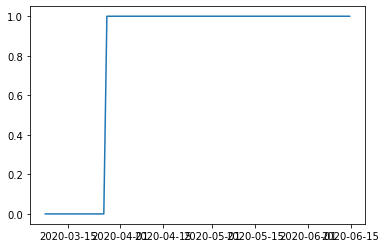

In [5]:
client = Client(api_key, api_secret)

crypto_bot = Cryptocurrency_bot(client=client, 
                                traded_asset_symbols=traded_asset_symbols, 
                                intervals=intervals, 
                                raw_price=raw_price, 
                                initial_plot=initial_plot)

In [6]:
def process_message(msg):
    global crypto_bot
    four_hours = 14400
    milliseconds = 1000
    percentage_to_trade = 0.9999

    msg = msg['data']['k']
    symbol = msg['s']
    interval = msg['i']
    pair = crypto_bot.pairs[symbol]
    pair_at_interval = pair.interval[interval]
    dataset = pair_at_interval.dataset
    precision = pair.info.precision
    if symbol in crypto_bot.pairs.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        pair_at_interval.dataset = dataset
        pair_at_interval.indicators.update(dataset, plot=False)
        pair.info.calculate_balance()
        pair.info.print_balance()

        if symbol == crypto_bot.traded_pair_symbol:
            volatility_trigger = pair_at_interval.indicators.volatility_trigger.value.iloc[-1]
            MACD_trigger = pair_at_interval.indicators.MACD_trigger.value.iloc[-1]
            real_trigger = pair_at_interval.indicators.real_trigger.value.iloc[-1]
            momentum_trigger = pair_at_interval.indicators.momentum_trigger.value.iloc[-1]

            if pair.state == 'exit':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

            elif pair.state == 'entry':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

bm = BinanceSocketManager(client, user_timeout=43200)

sockets = []

for interval in intervals:
    for symbol in crypto_bot.pairs.keys():
        sockets.append(symbol.lower() + '@kline_' + interval)

conn_key = bm.start_multiplex_socket(sockets, process_message)

bm.start()

'''
scores = {}
for crypto_pair in symbols.values():
    scores.update({crypto_pair.base_asset: 0})
    scores.update({crypto_pair.quote_asset: 0})

while True:
    time.sleep(15)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    scores = {}
    for crypto_pair in symbols.values():
        scores.update({crypto_pair.base_asset: 0})
        scores.update({crypto_pair.quote_asset: 0})

    for asset in scores.keys():
        for symbol in symbols.keys():
            if symbols[symbol].base_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] + 1})
                else:
                    scores.update({asset: scores[asset] - 1})
            elif symbols[symbol].quote_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] - 1})
                else:
                    scores.update({asset: scores[asset] + 1})

    assets = scores.keys()
    best_assets = [asset for asset in scores.keys() if scores[asset] > 0]
    print('best_assets: ', best_assets)

    if best_assets != [] and \
            not (symbols[traded_symbol].base_asset in best_assets or \
            symbols[traded_symbol].quote_asset in best_assets):

        if symbols[traded_symbol].position == 'buy':
            asset = symbols[traded_symbol].base_asset
        elif symbols[traded_symbol].position == 'sell':
            asset = symbols[traded_symbol].quote_asset

        target_symbols = [symbol for symbol in symbols.keys() \
                          if asset in symbol and any([asset in symbol for asset in best_assets])]

        target_symbol = target_symbols[0]
        symbols[target_symbol].state = 'exit'

        if symbols[target_symbol].base_asset == asset:
            symbols[target_symbol].position = 'buy'
        elif symbols[target_symbol].quote_asset == asset:
            symbols[target_symbol].position = 'sell'

        traded_symbol = target_symbol
'''

"\nscores = {}\nfor crypto_pair in symbols.values():\n    scores.update({crypto_pair.base_asset: 0})\n    scores.update({crypto_pair.quote_asset: 0})\n\nwhile True:\n    time.sleep(15)\n    for symbol in symbols.keys():\n        symbols[symbol].calculate_balance()\n        symbols[symbol].calculate_position()\n\n    scores = {}\n    for crypto_pair in symbols.values():\n        scores.update({crypto_pair.base_asset: 0})\n        scores.update({crypto_pair.quote_asset: 0})\n\n    for asset in scores.keys():\n        for symbol in symbols.keys():\n            if symbols[symbol].base_asset == asset:\n                if symbols[symbol].real_trigger.iloc[-1] and                         symbols[symbol].real_trigger_10m.iloc[-1]:\n                    scores.update({asset: scores[asset] + 1})\n                else:\n                    scores.update({asset: scores[asset] - 1})\n            elif symbols[symbol].quote_asset == asset:\n                if symbols[symbol].real_trigger.iloc[-1] and 

base_asset_balance:  4.18e-06
quote_asset_balance:  0.0
pair_last_price:  9454.87
pair_buy_balance:  0.0
pair_sell_balance:  0.0395213566
pair_combined_base_balance:  4.18e-06
pair_combined_quote_balance:  0.0395213566
base_asset_balance:  4.18e-06
quote_asset_balance:  0.0
pair_last_price:  9454.78
pair_buy_balance:  0.0
pair_sell_balance:  0.0395209804
pair_combined_base_balance:  4.18e-06
pair_combined_quote_balance:  0.0395209804
base_asset_balance:  4.18e-06
quote_asset_balance:  0.0
pair_last_price:  9454.78
pair_buy_balance:  0.0
pair_sell_balance:  0.0395209804
pair_combined_base_balance:  4.18e-06
pair_combined_quote_balance:  0.0395209804
base_asset_balance:  4.18e-06
quote_asset_balance:  0.0
pair_last_price:  9454.75
pair_buy_balance:  0.0
pair_sell_balance:  0.039520855
pair_combined_base_balance:  4.18e-06
pair_combined_quote_balance:  0.039520855
base_asset_balance:  4.18e-06
quote_asset_balance:  0.0
pair_last_price:  9454.74
pair_buy_balance:  0.0
pair_sell_balance:  0

In [ ]:
# --- Development separation --- #

In [ ]:
'''
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()
'''

In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()